In [0]:
%tensorflow_version 1.4
#from tensorflow.examples.tutorials.mnist import input_data
#mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)
import tensorflow as tf # I use version 1.4
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, seed=123)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4

In [0]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b
y_ = tf.placeholder(tf.float32, [None, 10])

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
def train_minibatch(opt_type, learning_rate, image_set, minibatch_size):
    # Arrays for logging accuracy and loss
    acc_log = np.zeros(len(image_set))
    loss_log = np.zeros(len(image_set))
    # Create optimizer
    opt = opt_type(learning_rate)
    #
    # minibatch operations
    #
    # 0) Retrieve trainable variables
    tvs = tf.trainable_variables() 
    # 1) Create placeholders for the accumulating gradients we'll be storing
    accum_vars = [tf.Variable(tv.initialized_value(),
                  trainable=False) for tv in tvs]
    # 2) Operation to initialize accum_vars to zero
    zero_ops  = [tv.assign(tf.zeros_like(tv)) for tv in accum_vars]
    # 3) Operation to compute the gradients for one minibatch
    gvs = opt.compute_gradients(loss)
    # 4) Operation to accumulate the gradients in accum_vars
    accum_ops = [accum_vars[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]
    # 5) Operation to perform the update (apply gradients)
    apply_ops = opt.apply_gradients([(accum_vars[i], tv) for i, tv 
                                     in enumerate(tf.trainable_variables())])
    # Create session to execute ops
    sess = tf.InteractiveSession()
    # Necessary initializations
    tf.set_random_seed(1234)
    tf.global_variables_initializer().run()
    # Train loop
    for i, batch in enumerate(image_set):
        # Make sure gradients are set to 0 before entering minibatch loop
        sess.run(zero_ops)
        # Loop over minibatches and execute accumulate-gradient operation
        for j in range(len(image_set) // minibatch_size):
            sess.run(accum_ops, 
                     feed_dict={x: batch[0][j*minibatch_size:(j+1)*minibatch_size],
                                y_: batch[1][j*minibatch_size:(j+1)*minibatch_size]})

        # Done looping over minibatches. Now apply gradients.
        sess.run(apply_ops)
        
        acc_log[i] = sess.run(accuracy, 
                              feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        loss_log[i] = sess.run(loss, 
                               feed_dict={x: mnist.test.images, y_: mnist.test.labels})

        #print("in iteration {}".format(i), sess.run(accum_vars))
    return acc_log, loss_log
#main function
#We are almost there! Let's now define our main function that does the comparison between train_standard and train_minibatch methods. Here we define a set of optimizers, try the comparison for each optimizer independently. We use the network's loss and accuracy as a comparison metric.

def compare(batch_size, minibatch_size, n_iterations):

    # Define optimizers (type, learning rate, and name) to be compared
    options = { tf.train.GradientDescentOptimizer : (0.03,  "SGD"),
                tf.train.AdagradOptimizer         : (0.001, "Adagrad"),
                tf.train.AdamOptimizer            : (0.001, "Adam"),
                tf.train.RMSPropOptimizer         : (0.0001,"RMSProp")
              }

    # Load a fixed set of images to run the training on
    image_set = get_images(batch_size=batch_size, n_iterations=n_iterations)

    # Loop over optimizers to compare
    for opt_type, (lr,name) in options.items():
        # Canvas making
        f, (ax0,ax1) = plt.subplots(1,2,figsize=(16,4),sharey=False,facecolor='w')
        f.suptitle('{} Batch {}'.format(name,batch_size), fontsize=20, fontname="Georgia")

        # accuracy plot
        ax0.set_ylabel("accuracy",fontsize=20,fontname="Georgia")
        ax0.set_xlabel("iterations",fontsize=20,fontname="Georgia")
        # loss plot
        ax1.set_ylabel("loss",fontsize=20,fontname="Georgia")
        ax1.set_xlabel("iterations",fontsize=20,fontname="Georgia")
        
        # "standard" training first
        acc_log, loss_log = train_standard  (opt_type=opt_type, 
                                             learning_rate=lr, 
                                             image_set=image_set)
        ax0.plot(acc_log,  'r.-', label="No minibatch")
        ax1.plot(loss_log, 'r.-', label="No minibatch")
        
        # "minibatch" training second
        acc_log, loss_log = train_minibatch (opt_type=opt_type, 
                                             learning_rate=lr, 
                                             image_set=image_set, 
                                             minibatch_size=minibatch_size)
        ax0.plot(acc_log, 'b', label="Minibatch {}".format(minibatch_size))
        ax1.plot(loss_log,'b', label="Minibatch {}".format(minibatch_size))

        # Show
        ax0.grid()
        ax1.grid()
        ax0.legend(loc=4,fontsize=16)
        ax1.legend(loc=3,fontsize=16)
        plt.show()

In [0]:
def compare(batch_size, minibatch_size, n_iterations):

    # Define optimizers (type, learning rate, and name) to be compared
    options = { #tf.train.GradientDescentOptimizer : (0.03,  "SGD"),
                tf.train.GradientDescentOptimizer : (0.001,  "SGD"),
                #tf.train.GradientDescentOptimizer : (0.7,  "SGD"),
                tf.train.AdagradOptimizer         : (0.001, "Adagrad"),
                tf.train.AdamOptimizer            : (0.001, "Adam"),
                tf.train.RMSPropOptimizer         : (0.0001,"RMSProp")
              }

    # Load a fixed set of images to run the training on
    image_set = get_images(batch_size=batch_size, n_iterations=n_iterations)

    # Loop over optimizers to compare
    for opt_type, (lr,name) in options.items():
        # Canvas making
        f, (ax0,ax1) = plt.subplots(1,2,figsize=(16,4),sharey=False,facecolor='w')
        f.suptitle('{} Batch {}'.format(name,batch_size), fontsize=20, fontname="Georgia")

        # accuracy plot
        ax0.set_ylabel("accuracy",fontsize=20,fontname="Georgia")
        ax0.set_xlabel("iterations",fontsize=20,fontname="Georgia")
        # loss plot
        ax1.set_ylabel("loss",fontsize=20,fontname="Georgia")
        ax1.set_xlabel("iterations",fontsize=20,fontname="Georgia")
        
        # "standard" training first
        acc_log, loss_log = train_standard  (opt_type=opt_type, 
                                             learning_rate=lr, 
                                             image_set=image_set)
        #ax0.plot(acc_log,  'r.-', label="No minibatch")
        #ax1.plot(loss_log, 'r.-', label="No minibatch")
        
        # "minibatch" training second
        acc_log, loss_log = train_minibatch (opt_type=opt_type, 
                                             learning_rate=lr, 
                                             image_set=image_set, 
                                             minibatch_size=minibatch_size)
        ax0.plot(acc_log, 'b', label="Minibatch {}".format(minibatch_size))
        ax1.plot(loss_log,'b', label="Minibatch {}".format(minibatch_size))

        # Show
        ax0.grid()
        ax1.grid()
        ax0.legend(loc=4,fontsize=16)
        ax1.legend(loc=3,fontsize=16)
        plt.show()

In [0]:
def get_images(batch_size, n_iterations):
    return [mnist.train.next_batch(batch_size = batch_size, shuffle=False) for _ in range(n_iterations)]

In [0]:
def train_standard(opt_type, learning_rate, image_set):
    # Arrays for logging accuracy and loss
    acc_log = np.zeros(len(image_set))
    loss_log = np.zeros(len(image_set))
    # Create optimizer
    opt = opt_type(learning_rate)
    #
    # no-minibatch (standard, simple) operation
    #
    minimize = opt.minimize(loss)
    # Create session to execute ops
    sess = tf.InteractiveSession()
    # Necessary initializations
    tf.set_random_seed(1234)
    tf.global_variables_initializer().run()
    # Train loop
    for i, batch in enumerate(image_set):
        sess.run(minimize, feed_dict={x: batch[0], y_: batch[1]})
        
        acc_log[i] = sess.run(accuracy, 
                              feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        loss_log[i] = sess.run(loss, 
                               feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        
    return acc_log, loss_log

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


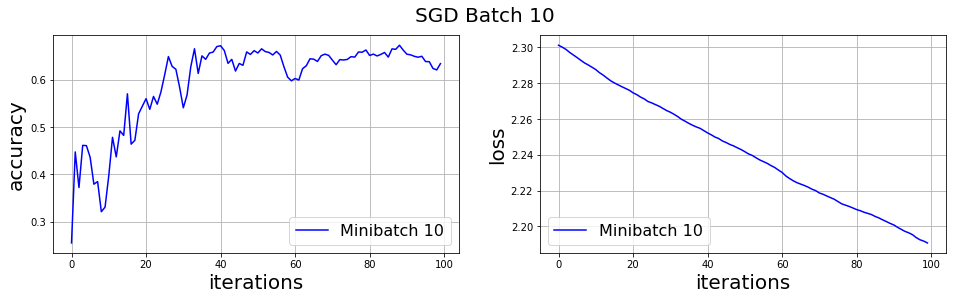

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


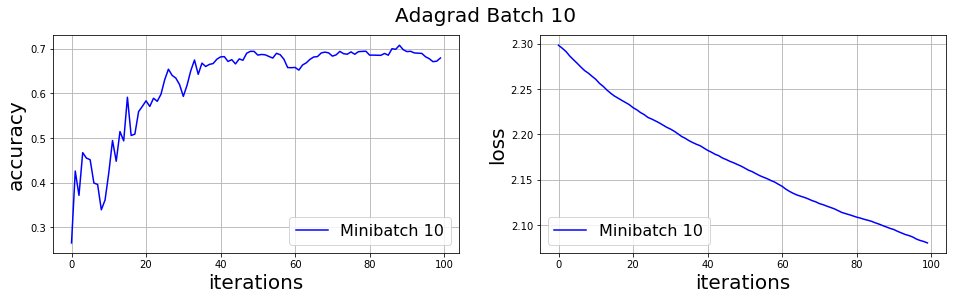

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


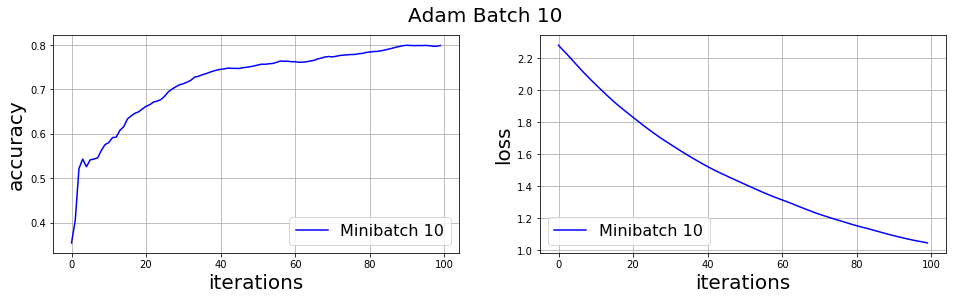

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


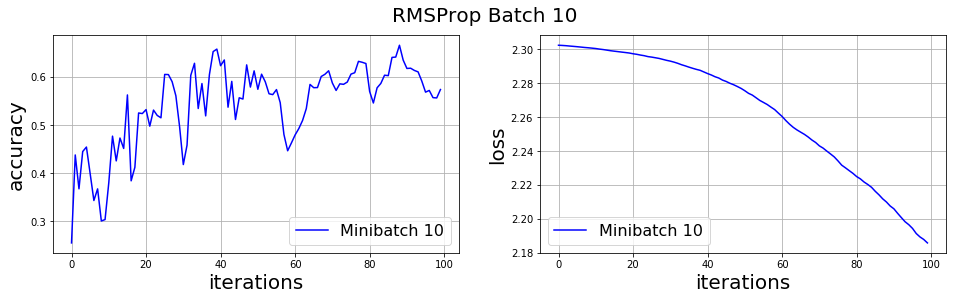

In [0]:
compare( batch_size     = 10,
         minibatch_size = 10,
         n_iterations   = 100)

In [0]:
x_train